In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import os
import matplotlib.pyplot as plt

In [6]:
class GMMN(nn.Module):
    def __init__(self, n_start, n_out):
        super(GMMN, self).__init__()
        self.fc1 = nn.Linear(n_start, 64)
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 784)
        self.fc5 = nn.Linear(784, n_out)

    def forward(self, samples):
        x = F.relu(self.fc1(samples))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        return x

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, n_inp, n_encoded):
        super(Autoencoder, self).__init__()
        self.encoder_fc1 = nn.Linear(n_inp, 1024)
        self.encoder_fc2 = nn.Linear(1024, n_encoded)

        self.decoder_fc1 = nn.Linear(n_encoded, 1024)
        self.decoder_fc2 = nn.Linear(1024, n_inp)

    def forward(self, x):
        e = self.encode(x)
        d = self.decode(e)
        return e, d

    def encode(self, x):
        e = F.sigmoid(self.encoder_fc1(x))
        e = F.sigmoid(self.encoder_fc2(e))
        return e

    def decode(self, x):
        d = F.sigmoid(self.decoder_fc1(x))
        d = F.sigmoid(self.decoder_fc2(d))
        return d

In [8]:
root = "./data"
model = "./models"

ENCODER_SAVE_PATH = model + "/autoencoder.pth"
GMMN_SAVE_PATH = model + "/gmmn.pth"

BATCH_SIZE = 100
N_INP = 784
NOISE_SIZE = 10
ENCODED_SIZE = 32
N_ENCODER_EPOCHS = 50
N_GEN_EPOCHS = 100

# visualization
N_COLS = 8
N_ROWS = 4

In [9]:
# Setup data and data loader
if not os.path.exists(root):
    os.mkdir(root)

if not os.path.exists(model):
    os.mkdir(model)

# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dataloader
trans = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST(root=root, train=True, transform=trans, download=True)
train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=BATCH_SIZE,
        shuffle=True)

100.1%

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


28.4%

113.5%

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


100.4%

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


180.4%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [11]:
# train the autoencoder first
encoder_net = Autoencoder(N_INP, ENCODED_SIZE).to(device)
encoder_optim = optim.Adam(encoder_net.parameters())

if os.path.exists(ENCODER_SAVE_PATH):
    encoder_net.load_state_dict(torch.load(ENCODER_SAVE_PATH))
    print("Loaded saved autoencoder model")
else:
    for ep in range(N_ENCODER_EPOCHS):
        avg_loss = 0
        for idx, (x, _) in enumerate(train_loader):
            x = x.view(x.size()[0], -1)
            x = Variable(x).to(device)
            _, decoded = encoder_net(x)
            loss = torch.sum((x - decoded) ** 2)
            encoder_optim.zero_grad()
            loss.backward()
            encoder_optim.step()
            avg_loss += loss.item()
        avg_loss /= (idx + 1)

        print("Autoencoder Training: Epoch - [%2d] complete, average loss - [%.4f]" %(ep + 1, avg_loss))

    torch.save(encoder_net.state_dict(), ENCODER_SAVE_PATH)

print("Autoencoder has been successfully trained")

/anaconda3/envs/torchenv/lib/python3.5/site-packages/torch/nn/functional.py:1101: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Autoencoder Training: Epoch - [ 1] complete, average loss - [4063.4407]
Autoencoder Training: Epoch - [ 2] complete, average loss - [2386.5339]
Autoencoder Training: Epoch - [ 3] complete, average loss - [1826.4986]
Autoencoder Training: Epoch - [ 4] complete, average loss - [1532.3025]
Autoencoder Training: Epoch - [ 5] complete, average loss - [1322.7790]
Autoencoder Training: Epoch - [ 6] complete, average loss - [1173.2865]
Autoencoder Training: Epoch - [ 7] complete, average loss - [1062.4136]
Autoencoder Training: Epoch - [ 8] complete, average loss - [969.2863]
Autoencoder Training: Epoch - [ 9] complete, average loss - [903.4435]
Autoencoder Training: Epoch - [10] complete, average loss - [851.2480]
Autoencoder Training: Epoch - [11] complete, average loss - [806.7884]
Autoencoder Training: Epoch - [12] complete, average loss - [766.2498]
Autoencoder Training: Epoch - [13] complete, average loss - [729.6790]
Autoencoder Training: Epoch - [14] complete, average loss - [699.2093]

In [12]:
# define the GMMN
gmm_net = GMMN(NOISE_SIZE, ENCODED_SIZE).to(device)
if os.path.exists(GMMN_SAVE_PATH):
    gmm_net.load_state_dict(torch.load(GMMN_SAVE_PATH))
    print("Loaded previously saved GMM Network")

gmmn_optimizer = optim.Adam(gmm_net.parameters(), lr=0.001)

def get_scale_matrix(M, N):
    s1 = (torch.ones((N, 1)) * 1.0 / N).to(device)
    s2 = (torch.ones((M, 1)) * -1.0 / M).to(device)
    return torch.cat((s1, s2), 0)

def train_one_step(x, samples, sigma=[1]):
    samples = Variable(samples).to(device)
    gen_samples = gmm_net(samples)
    X = torch.cat((gen_samples, x), 0)
    XX = torch.matmul(X, X.t())
    X2 = torch.sum(X * X, 1, keepdim=True)
    exp = XX - 0.5 * X2 - 0.5 * X2.t()

    M = gen_samples.size()[0]
    N = x.size()[0]
    s = get_scale_matrix(M, N)
    S = torch.matmul(s, s.t())

    loss = 0
    for v in sigma:
        kernel_val = torch.exp(exp / v)
        loss += torch.sum(S * kernel_val)

    loss = torch.sqrt(loss)

    gmmn_optimizer.zero_grad()
    loss.backward()
    gmmn_optimizer.step()

    return loss

In [13]:
# training loop
for ep in range(N_GEN_EPOCHS):
    avg_loss = 0
    for idx, (x, _) in enumerate(train_loader):
        x = x.view(x.size()[0], -1)
        with torch.no_grad():
            x = Variable(x).to(device)
            encoded_x = encoder_net.encode(x)

        # uniform random noise between [-1, 1]
        random_noise = torch.rand((BATCH_SIZE, NOISE_SIZE)) * 2 - 1
        loss = train_one_step(encoded_x, random_noise)
        avg_loss += loss.item()

    avg_loss /= (idx + 1)
    print("GMMN Training: Epoch - [%3d] complete, average loss - [%.4f]" %(ep, avg_loss))

torch.save(gmm_net.state_dict(), GMMN_SAVE_PATH)

/anaconda3/envs/torchenv/lib/python3.5/site-packages/torch/nn/functional.py:1101: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


GMMN Training: Epoch - [  0] complete, average loss - [0.2618]
GMMN Training: Epoch - [  1] complete, average loss - [0.1746]
GMMN Training: Epoch - [  2] complete, average loss - [0.1580]
GMMN Training: Epoch - [  3] complete, average loss - [0.1518]
GMMN Training: Epoch - [  4] complete, average loss - [0.1474]
GMMN Training: Epoch - [  5] complete, average loss - [0.1449]
GMMN Training: Epoch - [  6] complete, average loss - [0.1413]
GMMN Training: Epoch - [  7] complete, average loss - [0.1408]
GMMN Training: Epoch - [  8] complete, average loss - [0.1379]
GMMN Training: Epoch - [  9] complete, average loss - [0.1361]
GMMN Training: Epoch - [ 10] complete, average loss - [0.1364]
GMMN Training: Epoch - [ 11] complete, average loss - [0.1354]
GMMN Training: Epoch - [ 12] complete, average loss - [0.1346]
GMMN Training: Epoch - [ 13] complete, average loss - [0.1333]
GMMN Training: Epoch - [ 14] complete, average loss - [0.1328]
GMMN Training: Epoch - [ 15] complete, average loss - [

Comparision of outputs generated by autoencoder


/anaconda3/envs/torchenv/lib/python3.5/site-packages/torch/nn/functional.py:1101: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


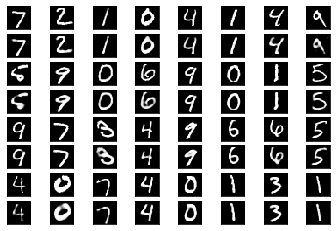

In [16]:


trans = transforms.Compose([transforms.ToTensor()])
test_set = datasets.MNIST(root=root, train=False, transform=trans, download=True)
view_data = [test_set[i][0] for i in range(N_ROWS * N_COLS)]

encoder_net = Autoencoder(N_INP, ENCODED_SIZE)
encoder_net.load_state_dict(torch.load(ENCODER_SAVE_PATH))

plt.gray()

to_visualize = "autoencoder" # "gmmn" or "autoencoder"
if to_visualize == "autoencoder":
    print("Comparision of outputs generated by autoencoder")
    for i in range(N_ROWS * N_COLS):
        # original image
        r = i // N_COLS
        c = i % N_COLS + 1
        ax = plt.subplot(2 * N_ROWS, N_COLS, 2 * r * N_COLS + c)
        plt.imshow(view_data[i].squeeze())
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # reconstructed image
        ax = plt.subplot(2 * N_ROWS, N_COLS, 2 * r * N_COLS + c + N_COLS)
        x = Variable(view_data[i])
        _, y = encoder_net(x.view(1, -1))
        plt.imshow(y.detach().squeeze().numpy().reshape(28, 28))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

elif to_visualize == "gmmn":
    print("Images generated by GMMN")
    gmm_net = GMMN(NOISE_SIZE, ENCODED_SIZE)
    gmm_net.load_state_dict(torch.load(GMMN_SAVE_PATH))

    for r in range(N_ROWS):
        for c in range(N_COLS):
            ax = plt.subplot(N_ROWS, N_COLS, r * N_COLS + c + 1)

            noise = torch.rand((1, NOISE_SIZE)) * 2 - 1
            encoded_x = gmm_net(Variable(noise))
            y = encoder_net.decode(encoded_x)

            plt.imshow(y.detach().squeeze().numpy().reshape(28, 28))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
plt.show()